In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('pml_train.csv')
df_test = pd.read_csv('pml_test_features.csv')

In [3]:
cont_features = []
cat_features = []
for c in df_train.columns:
    if 'cont' in c:
        cont_features.append(c)
    elif 'cat' in c:
        cat_features.append(c)

# Exploratory Analysis:

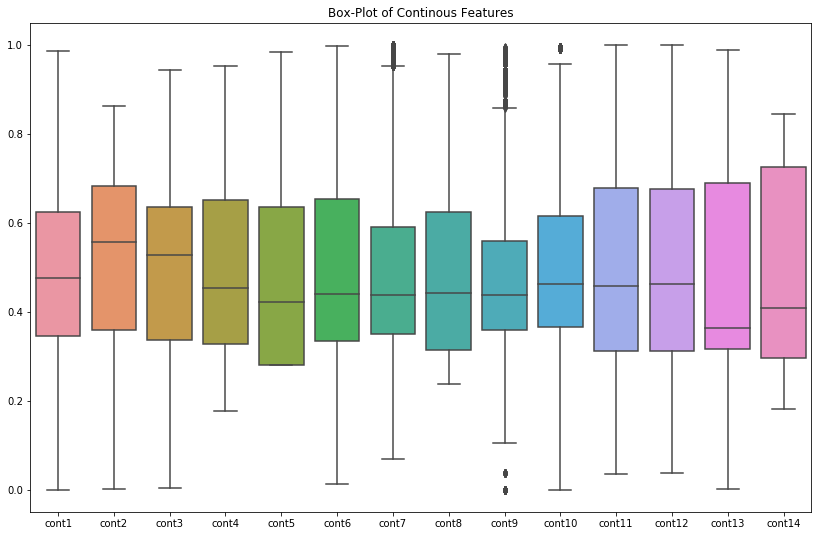

In [5]:
plt.figure(figsize=(14,9))
sns.boxplot(data=df_train[cont_features])
plt.title('Box-Plot of Continous Features')

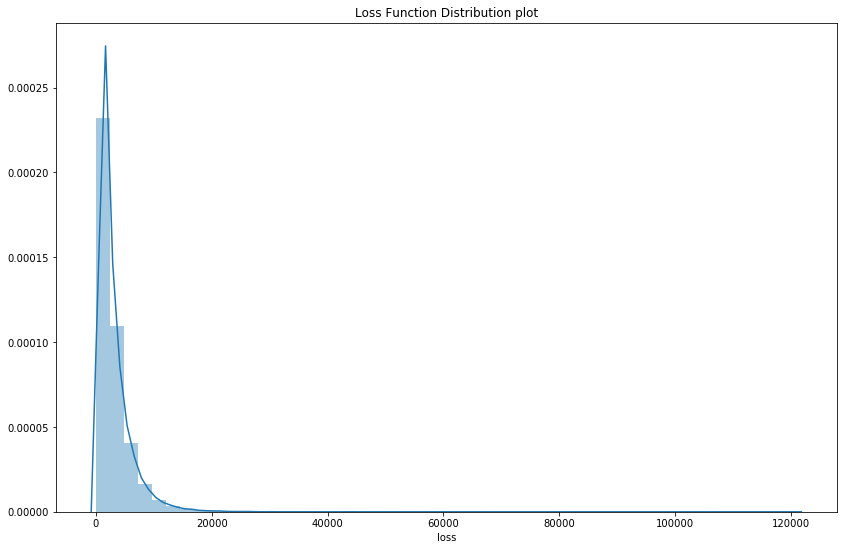

In [6]:
plt.figure(figsize=(14,9))
sns.distplot(df_train['loss'])
plt.title('Loss Function Distribution plot')

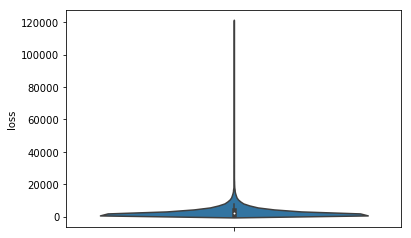

In [4]:
sns.violinplot(data=df_train,y='loss')
plt.show()

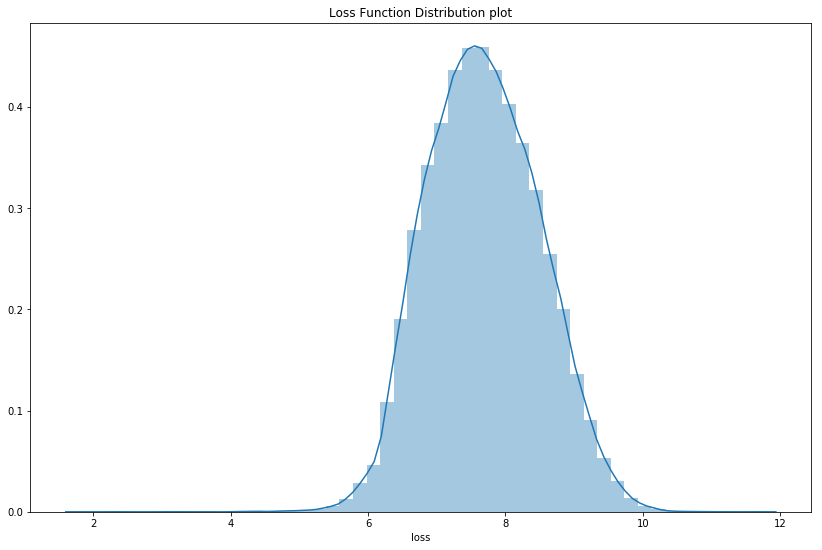

In [5]:
# since all values of loss are so small, use log1p to 
# normalize distribution of loss
plt.figure(figsize=(14,9))
sns.distplot(np.log1p(df_train['loss']))
plt.title('Loss Function Distribution plot')

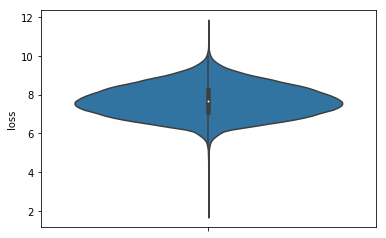

In [6]:
df_train['loss']= np.log1p(df_train['loss'])
sns.violinplot(data=df_train,y='loss')
plt.show()
# improved skew, but still some exists in the bottom quartile

## Correlation Matrix:

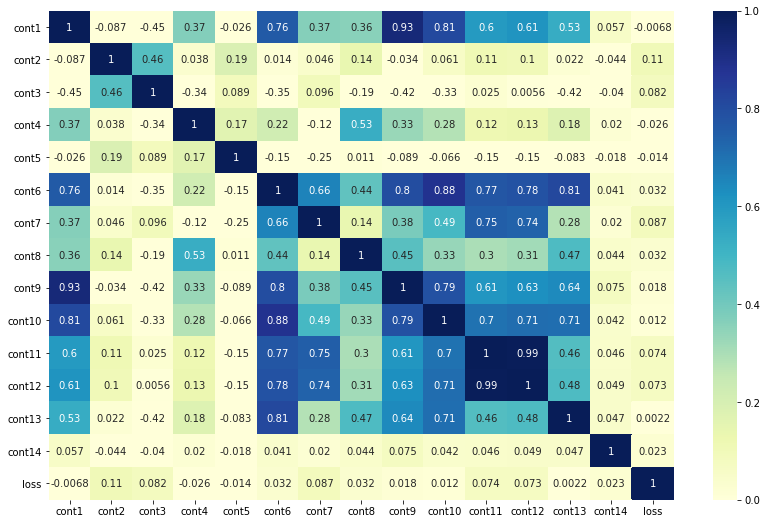

In [7]:
cont_features.append('loss')
corr_cont = df_train[cont_features].corr()
corrMat = corr_cont.as_matrix()
corr_list = []
plt.figure(figsize=(14,9))
sns.heatmap(corr_cont,annot=True,vmin=0,vmax=1,cmap='YlGnBu')
plt.show()

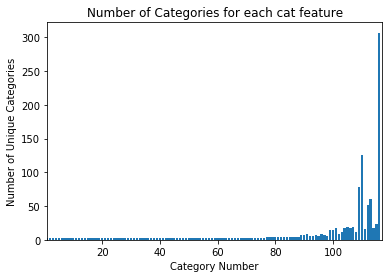

In [8]:
plt.bar(np.arange(1,117),height=np.array(df_train[cat_features].nunique()))
plt.xlim([1,117])
plt.xlabel('Category Number')
plt.ylabel('Number of Unique Categories')
plt.title('Number of Categories for each cat feature')

## Encode Categorical Features

Since many of the categorical features are non-numerical, I decided to use a one-hot encoding scheme to convert may of 

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
labels =[]
for c in cat_features:
    train = df_train[c].unique()
    test = df_test[c].unique()
    labels.append(list(set(train) | set(test)))
cats = []
cats_test =[]
for i,v in enumerate(cat_features):
    #Label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(labels[i])
    feature = label_encoder.transform(df_train[v])
    f_test = label_encoder.transform(df_test[v])
    feature = feature.reshape(df_train.shape[0], 1)
    f_test = f_test.reshape(df_test.shape[0],1)
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    feature = onehot_encoder.fit_transform(feature)
    f_test = onehot_encoder.fit_transform(f_test)
    cats.append(feature)
    cats_test.append(f_test)
encoded_cats = np.column_stack(cats)
encoded_catsTest=np.column_stack(cats_test)
    

In [10]:
dataset_encoded = np.concatenate((encoded_cats,df_train[cont_features].values),axis=1)
cont_features.remove('loss')
dataTestE = np.concatenate((encoded_catsTest,df_test[cont_features].values),axis=1)

# Machine Learning:

In [11]:
from sklearn.metrics import mean_absolute_error
import time

In [12]:
rows, columns = dataset_encoded.shape
data = dataset_encoded[:,0:(columns-1)] # remove loss column
loss = dataset_encoded[:,(columns-1)] # loss column

## Lasso Algorithm

In [13]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [16]:
seed = 2016
lasso = Lasso(random_state=seed)
alphas = np.logspace(-4,0,30)

tuned_parameters = [{'alpha':alphas}]
n_folds = 3

# Hyper-Parameter Tuning with Nested CV:
clf = GridSearchCV(lasso,tuned_parameters, cv = n_folds,scoring='neg_mean_absolute_error')
clf.fit(data,loss)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [18]:
times = clf.cv_results_['mean_fit_time']

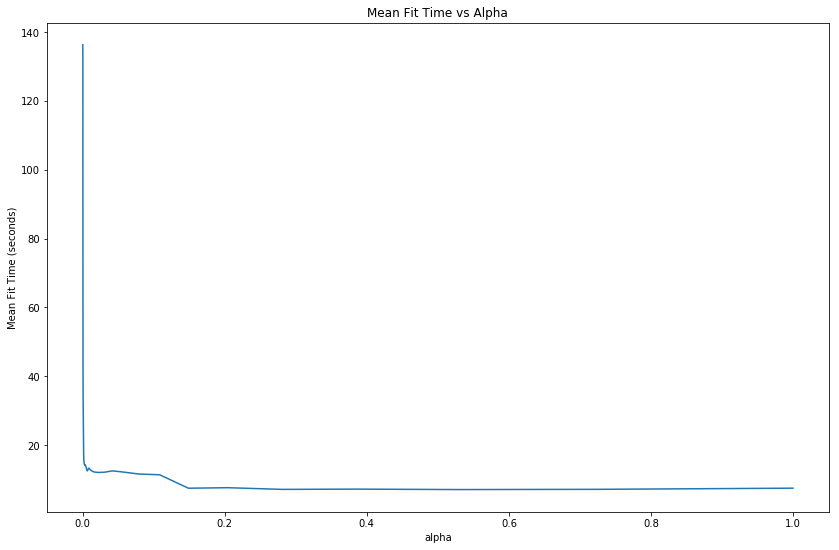

In [23]:
plt.figure(figsize=(14,9))
plt.plot(alphas,times)
plt.title('Mean Fit Time vs Alpha')
plt.xlabel('alpha')
plt.ylabel('Mean Fit Time (seconds)')
plt.show()

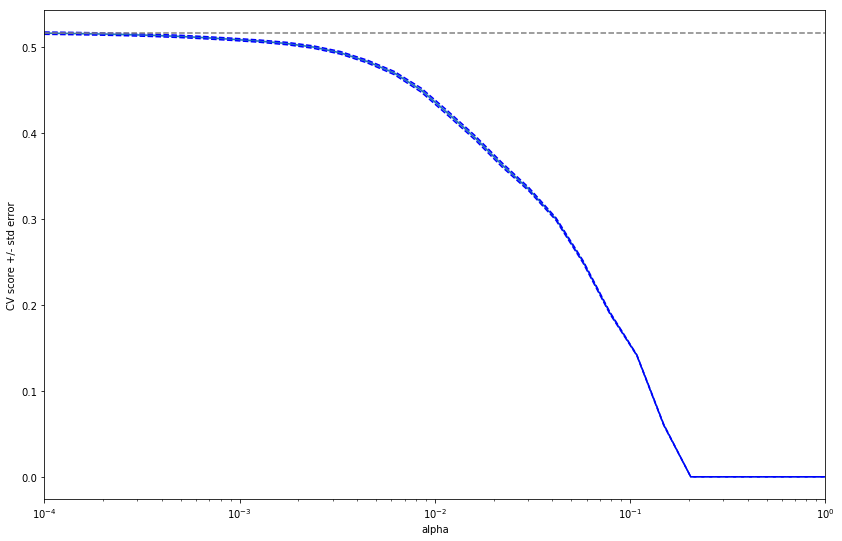

In [15]:
plt.figure(figsize=(14,9))
plt.semilogx(alphas,scores)
# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

In [53]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
scores

array([ 5.16069009e-01,  5.15660067e-01,  5.15155616e-01,  5.14455964e-01,
        5.13528053e-01,  5.12331654e-01,  5.10733259e-01,  5.08882388e-01,
        5.06782679e-01,  5.04016227e-01,  4.99832798e-01,  4.93169141e-01,
        4.83001252e-01,  4.69620319e-01,  4.49721771e-01,  4.22483511e-01,
        3.94223621e-01,  3.62746409e-01,  3.34176916e-01,  2.99737583e-01,
        2.50275995e-01,  1.90533838e-01,  1.41410142e-01,  6.03400856e-02,
       -9.19934907e-06, -9.19934907e-06, -9.19934907e-06, -9.19934907e-06,
       -9.19934907e-06, -9.19934907e-06])

In [55]:
predictions = np.expm1(clf.predict(dataTestE))

In [56]:
predLoss = pd.Series(predictions,name='loss')
submission  = pd.concat([df_test['id'],predLoss],axis=1)

In [58]:
submission.to_csv('submission-LASSO.csv',index=False) #Scored: 1239.0284 

## XGBoost Algorithm

In [27]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import time
import scipy.stats as stats

In [28]:
rows, columns = dataset_encoded.shape
data = dataset_encoded[:,0:(columns-1)] # remove loss column
loss = dataset_encoded[:,(columns-1)] # loss column

In [ ]:
seed = 2016
model = XGBRegressor(seed=2016,learning_rate=0.3,n_jobs=-1)

In [23]:
estimators= stats.randint(110,200)
max_depth = range(3,6)
learning_rate = stats.uniform(0.01,0.07)
colsample_bytree = stats.uniform(0.5,0.45)
min_child_weight= range(1,4)

tuned_parameters={'n_estimators':estimators,
                    'max_depth': max_depth,}
# learning_rate': learning_rate',
#                     'colsample_bytree': colsample_bytree,
#                     'min_child_weight': min_child_weight
n_folds = 3
clf = RandomizedSearchCV(model,param_distributions=tuned_parameters, cv = n_folds, 
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,verbose=1)

In [19]:
model.fit(data,loss,eval_metric='mae')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2016,
       silent=True, subsample=1)

In [20]:
predictions = np.expm1(model.predict(dataTestE))

In [21]:
predictions

array([1401.5009, 1431.4539, 3974.6248, ..., 1353.4996, 3306.5022,
       3045.555 ], dtype=float32)

In [22]:
predLoss = pd.Series(predictions,name='loss')
submission  = pd.concat([df_test['id'],predLoss],axis=1)
submission.to_csv('submission-XGBOOST2.csv',index=False) #Scored: 1239.0284 

In [ ]:
clf.fit(data,loss)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
scores = clf.cv_results_['neg_mean_absolute_error']
scores_mt = clf.cv_results['mean_test_score']
scores_std = clf.cv_results['std_test_score']

In [29]:
from sklearn.model_selection import cross_val_score

model = XGBRegressor(seed=2016,max_depth=7)
scores = cross_val_score(model, data, loss, cv=4)

In [30]:
scores

array([0.5430061 , 0.55242186, 0.55276236, 0.55382748])